In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Admin',
    database='ecommerce'
)

cursor = db.cursor()

# List all unique cities where customers are located.

In [2]:
query = """ select distinct customer_city from customers"""
cursor.execute(query)

data = cursor.fetchall()

df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [3]:
query = """ SELECT COUNT(order_id) FROM `orders` WHERE YEAR(order_purchase_timestamp) = 2017"""
cursor.execute(query)

data = cursor.fetchall()

data[0][0]

45101

# Find the total sales per category.

In [4]:
query = """
SELECT 
    products.product_category AS category, 
    round(SUM(payments.payment_value),2) AS sales
FROM products
JOIN order_items 
    ON products.product_id = order_items.product_id
JOIN payments 
    ON payments.order_id = order_items.order_id
GROUP BY category
        """
cursor.execute(query)

data = cursor.fetchall()

df = pd.DataFrame(data,columns=["Category","Sales"])
df.head()

,Category,Sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33


# Calculate the percentage of orders that were paid in installments.

In [5]:
query = """
SELECT 
    (SUM(CASE WHEN payment_installments >= 1 THEN 1 ELSE 0 END) * 100.0) / COUNT(*) AS percentage
FROM payments;
        """
cursor.execute(query)

data = cursor.fetchall()

data[0][0]

Decimal('99.99807')

# Count the number of customers from each state. 

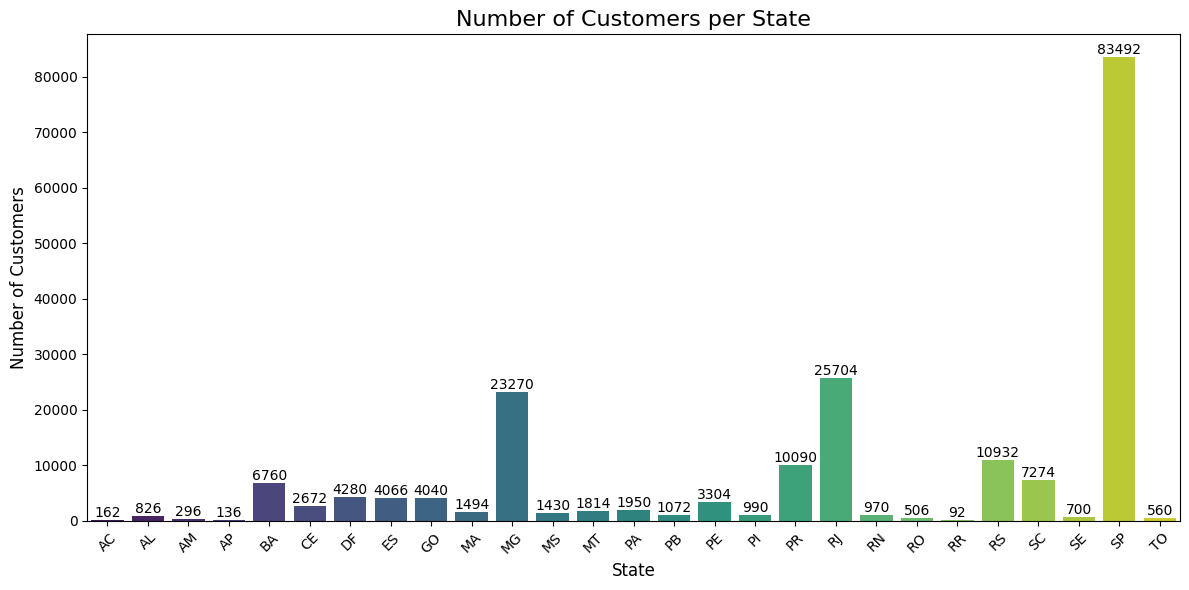

In [6]:
query = """
SELECT customer_state, COUNT(customer_id) 
FROM customers 
GROUP BY customer_state;
"""
cursor.execute(query)

# --- Fetch Data ---
data = cursor.fetchall()

# --- Create DataFrame ---
df = pd.DataFrame(data, columns=["States", "No of Customer"])

# --- Optional: Sort by number of customers (descending order) ---
df = df.sort_values(by="States", ascending=True)

# --- Plot Bar Chart using Seaborn ---
plt.figure(figsize=(12,6))  # Set figure size
ax = sns.barplot(x="States", y="No of Customer", hue="States", data=df, palette="viridis", legend=False)

for container in ax.containers:
    ax.bar_label(container)

# --- Customize Chart ---
plt.title("Number of Customers per State", fontsize=16)
plt.xlabel("State", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# --- Show Chart ---
plt.show()

# Calculate the number of orders per month in 2018.

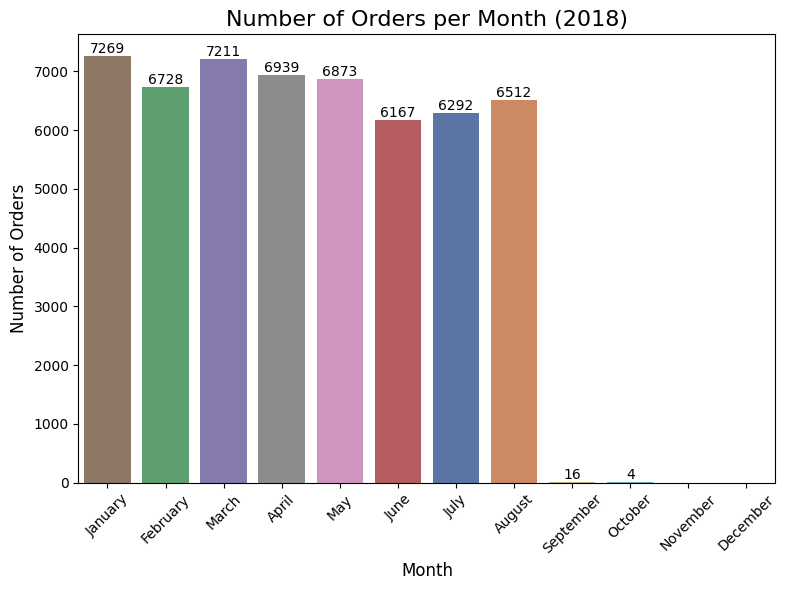

In [7]:
query = """
SELECT monthname(order_purchase_timestamp) months, COUNT(order_id) FROM orders where year(order_purchase_timestamp) = 2018 GROUP BY months;
        """
cursor.execute(query)

data = cursor.fetchall()

df = pd.DataFrame(data, columns=["Month", "Orders/Months"])

plt.figure(figsize=(8,6))

month_order = [
    'January','February','March','April','May','June',
    'July','August','September','October','November','December'
]

ax = sns.barplot(
    x="Month",
    y="Orders/Months",
    hue="Month",
    data=df,
    order=month_order,
    palette="deep",
    legend=False
)

for container in ax.containers:
    ax.bar_label(container)

plt.title("Number of Orders per Month (2018)", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Orders", fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# Find the average number of products per order, grouped by customer city.

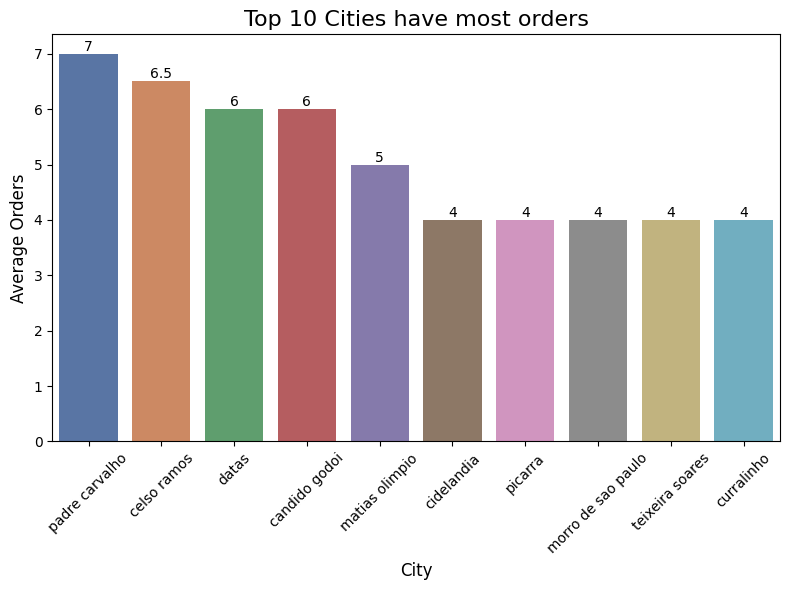

In [8]:
query = """
WITH count_per_order AS (
    SELECT 
        orders.order_id,
        orders.customer_id,
        COUNT(order_items.order_id) AS oc
    FROM orders
    JOIN order_items 
        ON orders.order_id = order_items.order_id
    GROUP BY orders.order_id, orders.customer_id
)

SELECT 
    customers.customer_city,
    ROUND(AVG(count_per_order.oc), 2) AS avg_orders
FROM customers
JOIN count_per_order 
    ON customers.customer_id = count_per_order.customer_id
GROUP BY customers.customer_city order by avg_orders DESC;
        """
cursor.execute(query)

data = cursor.fetchall()

df = pd.DataFrame(data, columns=["City","Avg_Orders"])
t_data = df.head(10)

plt.figure(figsize=(8,6))

ax = sns.barplot(
    x="City",
    y="Avg_Orders",
    hue="City",
    data=t_data,
    palette="deep",
    legend=False
)

for container in ax.containers:
    ax.bar_label(container)

plt.title("Top 10 Cities have most orders", fontsize=16)
plt.xlabel("City", fontsize=12)
plt.ylabel("Average Orders", fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#  Calculate the percentage of total revenue contributed by each product category.

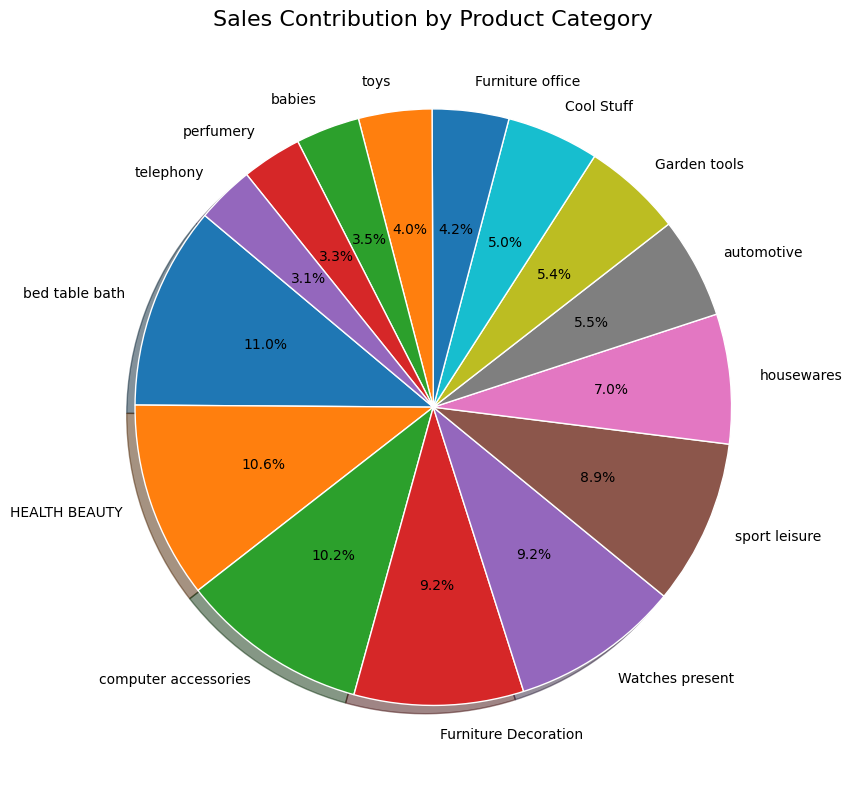

In [9]:
query = """
SELECT 
    products.product_category AS category, 
    ROUND((SUM(payments.payment_value) / (SELECT SUM(payment_value) FROM payments) * 100), 3) AS sales
FROM products
JOIN order_items 
    ON products.product_id = order_items.product_id
JOIN payments 
    ON payments.order_id = order_items.order_id
GROUP BY category 
ORDER BY sales DESC;
"""
cursor.execute(query)

data = cursor.fetchall()

# Create DataFrame
df = pd.DataFrame(data, columns=["Category", "Sales_Percent"])
p_data = df.head(15)

# --- Pie Chart ---
plt.figure(figsize=(10,8))
plt.pie(
    p_data["Sales_Percent"],
    labels=p_data["Category"],
    autopct="%1.1f%%",      # shows percentage on pie
    startangle=140,         # start angle for better layout
    wedgeprops={"edgecolor": "white"}, 
    shadow=True
)

plt.title("Sales Contribution by Product Category", fontsize=16)
plt.tight_layout()
plt.show()


# Identify the correlation between product price and the number of times a product has been purchased.

In [10]:
query = """
SELECT products.product_category,
       Count(order_items.product_id),
       Round(Avg(order_items.price), 2)
FROM   products
       JOIN order_items
         ON products.product_id = order_items.product_id
GROUP  BY products.product_category; ;
"""
cursor.execute(query)

data = cursor.fetchall()
df = pd.DataFrame(data,columns =["Category","Order Count","Price"])

arr1 = df["Order Count"]
arr2 = df["Price"]
a = np.corrcoef([arr1,arr2])

print("The correlation between product price and the number of times a product has been purchased is :",a[0][1])

The correlation between product price and the number of times a product has been purchased is : -0.10631514167157562


# Calculate the total revenue generated by each seller, and rank them by revenue.

In [11]:
query = """
SELECT 
    *, 
    RANK() OVER (ORDER BY revenue DESC) AS rn
FROM (
    SELECT 
        order_items.seller_id,
        SUM(payments.payment_value) AS revenue
    FROM order_items
    JOIN payments 
        ON order_items.order_id = payments.order_id
    GROUP BY order_items.seller_id
) AS a;
"""
cursor.execute(query)

data = cursor.fetchall()

df = pd.DataFrame(data)
df.head(20)

,0,1,2
0,7c67e1448b00f6e969d365cea6b010ab,507166.907302,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.039840,2
2,4a3ca9315b744ce9f8e9374361493884,301245.269765,3
3,1f50f920176fa81dab994f9023523100,290253.420128,4
4,53243585a1d6dc2643021fd1853d8905,284903.080498,5
5,da8622b14eb17ae2831f4ac5b9dab84a,272219.319315,6
6,4869f7a5dfa277a7dca6462dcf3b52b2,264166.120939,7
7,955fee9216a65b617aa5c0531780ce60,236322.300502,8
8,fa1c13f2614d7b5c4749cbc52fecda94,206513.229870,9
9,7e93a43ef30c4f03f38b393420bc753a,185134.209706,10
